# <center> HR Analytics: Job change of Data scientists</center>
<center>Predict who will move to a new job.</center>
<a href=https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists>Kaggle link </a><br>
<b>Features</b>
<ul>
<li>enrollee_id : Unique ID for candidate</li>
<li>city: City code</li>
<li>city_ development _index : Developement index of the city (scaled)</li>
<li>gender: Gender of candidate</li>
<li>relevent_experience: Relevant experience of candidate</li>
<li>enrolled_university: Type of University course enrolled if any</li>
<li>education_level: Education level of candidate</li>
<li>major_discipline :Education major discipline of candidate</li>
<li>experience: Candidate total experience in years</li>
<li>company_size: No of employees in current employer's company</li>
<li>company_type : Type of current employer</li>
<li>lastnewjob: Difference in years between previous job and current job</li>
<li>training_hours: training hours completed</li>
<li>target: 0 – Not looking for job change, 1 – Looking for a job change</li>
    </ul>

In [1]:
# Code for showing toggle button for showing/hiding the code
# While exporting this Jupyter notebook to html for presentation purpose, hide the code for analytical view
from IPython.display import HTML,Image,display
HTML('''
<script>
code_show=true;
function code_toggle(){
if (code_show){
$('div.input').hide();
$("#btn_toggle").val("Show Code");
}else{
$('div.input').show();
$("#btn_toggle").val("Hide Code");
}
code_show= !code_show;
}
</script>
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
<form action="javascript:code_toggle()">
<input style = "float:right" type="submit" id="btn_toggle" value="Hide Code">
''')

In [2]:
#import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.display import HTML,display
from wordcloud import WordCloud
from tqdm import tqdm

import mlxtend
from mlxtend.preprocessing import standardize

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV


In [3]:
#Visualization settings
sns.set_style(style='white')
sns.set(rc={
    'figure.figsize': (12,7),
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.color': '.9',
    'axes.linewidth': 1.0,
    'grid.linestyle': u'-'},
    font_scale=1.5)
custom_colors=["#3498db", "#95a5a6","#34495e", "#2ecc71", "#e74c3c"]
sns.set_palette(custom_colors)

## <center>Dataset description</center>

In [4]:
#For kaggle environment, enter the default input path here.
input_dir=''

In [5]:
df_train=pd.read_csv(input_dir+'aug_train.csv')
print (f"Training data loaded with {df_train.shape[0]} rows and columns {df_train.shape[1]}")
print ("Sampledata frame:")
df_train.head(3)

Training data loaded with 19158 rows and columns 14
Sampledata frame:


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0


In [6]:
col_tags="<ol><b>" + "".join([f"<li>{col}</li>" for col in df_train.columns]) + "</b></ol>"
display(HTML("<b><u>Feature names</u></b>"))
display(HTML(col_tags))
print ("Dataset summary")
df_train.info()

Dataset summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2

<h4 style='background-color:yellow'>
2 float <br>
2 integer<br>
10 string features
</h4>

              Features  NullCount
0         company_type       6140
1         company_size       5938
2               gender       4508
3     major_discipline       2813
4      education_level        460
5         last_new_job        423
6  enrolled_university        386
7           experience         65


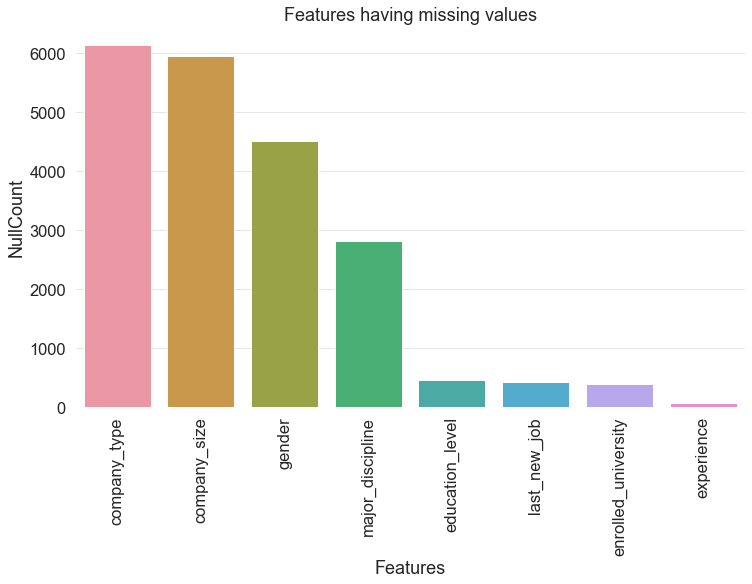

In [7]:
val=df_train.isnull().sum()
val.sort_values(inplace=True,ascending=False)
df=pd.DataFrame(columns=["Features","NullCount"])
df["Features"]=val.index
df["NullCount"]=val.values
df.drop(df[df["NullCount"]==0].index,inplace=True)
print (df)
sns.barplot(data=df,x="Features",y="NullCount")
plt.xticks(rotation=90)
plt.title("Features having missing values");

## <center>Exploratory Data Analysis</center>

In [8]:
#Discrete feature analysis
def analyze_discrete_feature(fld):
    df=pd.DataFrame({"Value": fld.value_counts().index,
                 "Count":fld.value_counts().values})
    print ("Null value count : ", fld.isnull().sum())
    unique_list=fld.unique().tolist()
    print ("\nUnique values: ", unique_list)
    print ("\n Unique values count: ", len(unique_list))
    print ("\nValue counts:\n",    df)
    plt.subplots(figsize=(25,10))
    plt.subplot(2,2,1)
    plt.pie(fld.value_counts(),labels=fld.value_counts().index,autopct=lambda x: f'{x: .2f}%');
    plt.xticks(rotation=90)
    plt.subplot(2,2,2)
    
    sns.barplot(data=df, x="Value",y="Count");
    plt.xticks(rotation=90);
    plt.suptitle(fld.name + " -distribution");
    plt.show()
    plt.close()
    display(HTML("<h4 style='background-color:yellow'>Discrete variable</h4>"))

In [9]:
#Continuous feature analysis
def analyze_continuous_feature(fld):
    print ("Null value count : ", fld.isnull().sum())
    print ("\n", fld.describe())
    plt.subplots(figsize=(25,10))
    plt.subplot(2,2,1)
    plt.hist(fld)
    plt.subplot(2,2,2)
    sns.boxplot(fld)
    plt.suptitle("fld.name + -distribution")
    plt.show()
    plt.close()
    display(HTML("<h4 style='background-color:yellow'>Continuous variable</h4>"))
    

### 1. enrollee Id

In [10]:
df_train.enrollee_id.describe()

count    19158.000000
mean     16875.358179
std       9616.292592
min          1.000000
25%       8554.250000
50%      16982.500000
75%      25169.750000
max      33380.000000
Name: enrollee_id, dtype: float64

<h4 style='background-color:yellow'>
Integer feature. <br>
Identifier of the rows.
</h4>

### 2. City

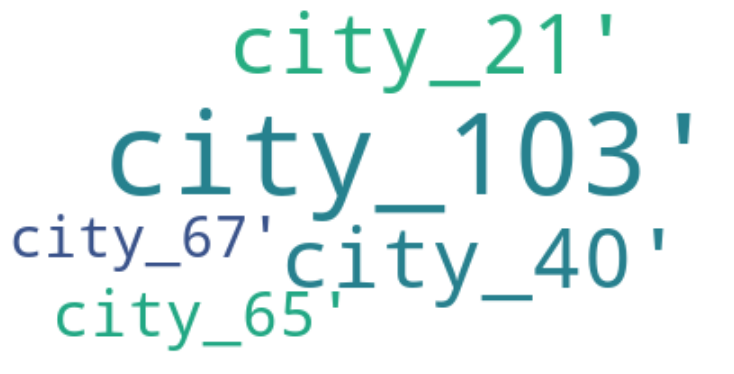

In [11]:
wc=WordCloud(background_color='white').generate(str(df_train.city.values))
plt.figure(figsize=(10,10),facecolor=None)
plt.imshow(wc,interpolation='bilinear');
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Null value count :  0

Unique values:  ['city_103', 'city_40', 'city_21', 'city_115', 'city_162', 'city_176', 'city_160', 'city_46', 'city_61', 'city_114', 'city_13', 'city_159', 'city_102', 'city_67', 'city_100', 'city_16', 'city_71', 'city_104', 'city_64', 'city_101', 'city_83', 'city_105', 'city_73', 'city_75', 'city_41', 'city_11', 'city_93', 'city_90', 'city_36', 'city_20', 'city_57', 'city_152', 'city_19', 'city_65', 'city_74', 'city_173', 'city_136', 'city_98', 'city_97', 'city_50', 'city_138', 'city_82', 'city_157', 'city_89', 'city_150', 'city_70', 'city_175', 'city_94', 'city_28', 'city_59', 'city_165', 'city_145', 'city_142', 'city_26', 'city_12', 'city_37', 'city_43', 'city_116', 'city_23', 'city_99', 'city_149', 'city_10', 'city_45', 'city_80', 'city_128', 'city_158', 'city_123', 'city_7', 'city_72', 'city_106', 'city_143', 'city_78', 'city_109', 'city_24', 'city_134', 'city_48', 'city_144', 'city_91', 'city_146', 'city_133', 'city_126', 'city_118', 'city_9', 'city_167', '

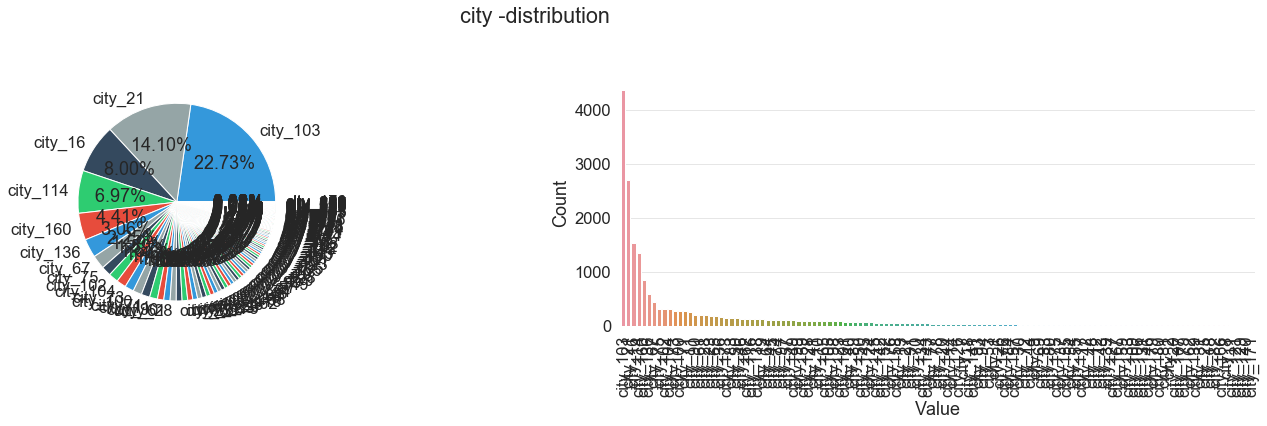

In [12]:
analyze_discrete_feature(df_train.city)

### 3. city_development_index

Null value count :  0

 count    19158.000000
mean         0.828848
std          0.123362
min          0.448000
25%          0.740000
50%          0.903000
75%          0.920000
max          0.949000
Name: city_development_index, dtype: float64


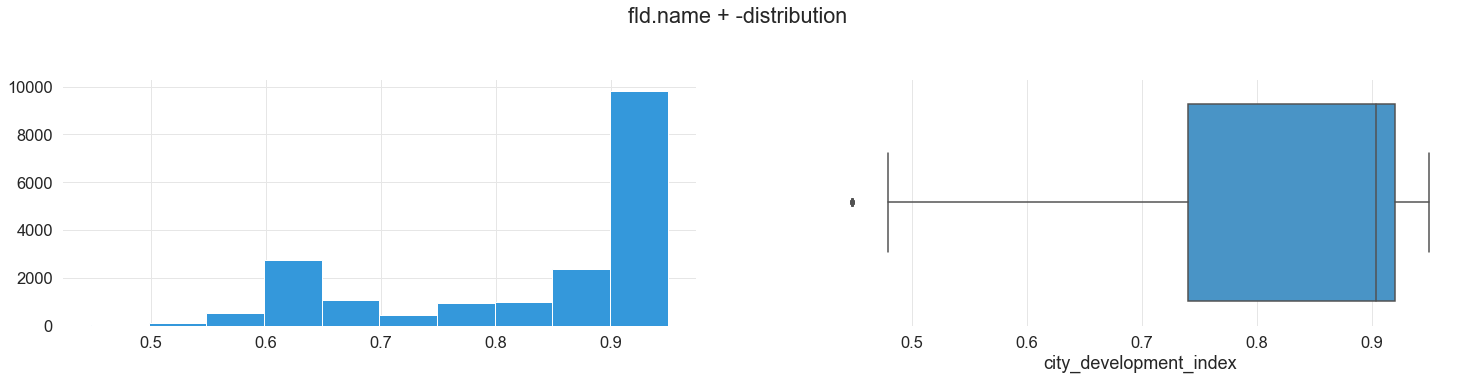

In [13]:
analyze_continuous_feature(df_train.city_development_index)

### 4. Gender

Null value count :  4508

Unique values:  ['Male', nan, 'Female', 'Other']

 Unique values count:  4

Value counts:
     Value  Count
0    Male  13221
1  Female   1238
2   Other    191


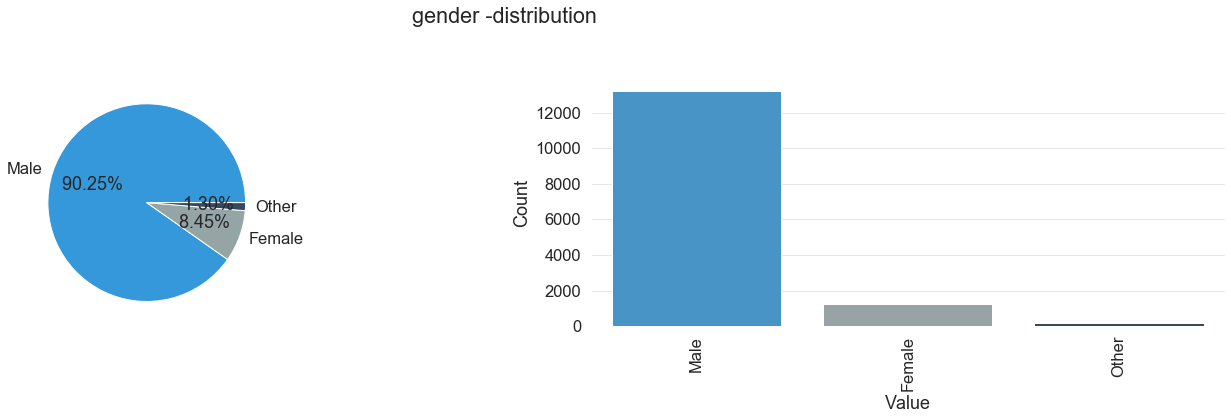

In [14]:
analyze_discrete_feature(df_train.gender)

<h4 style='background-color:yellow'>
    Majority is the male candidates.
</h4>

### 5. relevent_experience

Null value count :  0

Unique values:  ['Has relevent experience', 'No relevent experience']

 Unique values count:  2

Value counts:
                      Value  Count
0  Has relevent experience  13792
1   No relevent experience   5366


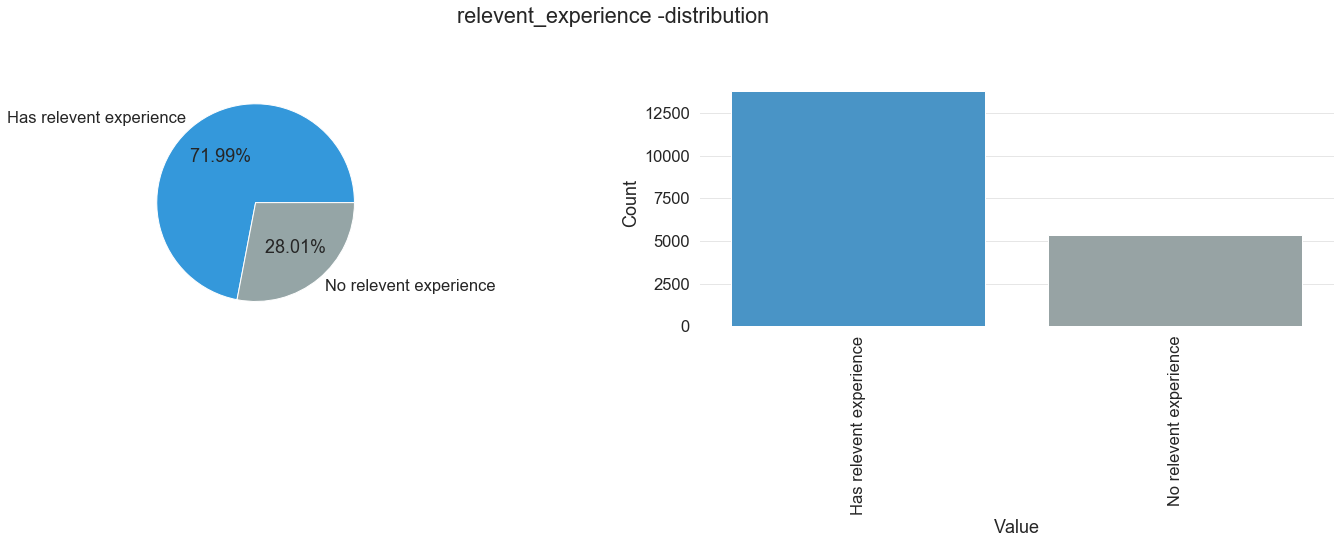

In [15]:
analyze_discrete_feature(df_train.relevent_experience)

<h4 style='background-color:yellow'>
Most of the candidates having the experience.
</h4>


### 6. enrolled_university

Null value count :  386

Unique values:  ['no_enrollment', 'Full time course', nan, 'Part time course']

 Unique values count:  4

Value counts:
               Value  Count
0     no_enrollment  13817
1  Full time course   3757
2  Part time course   1198


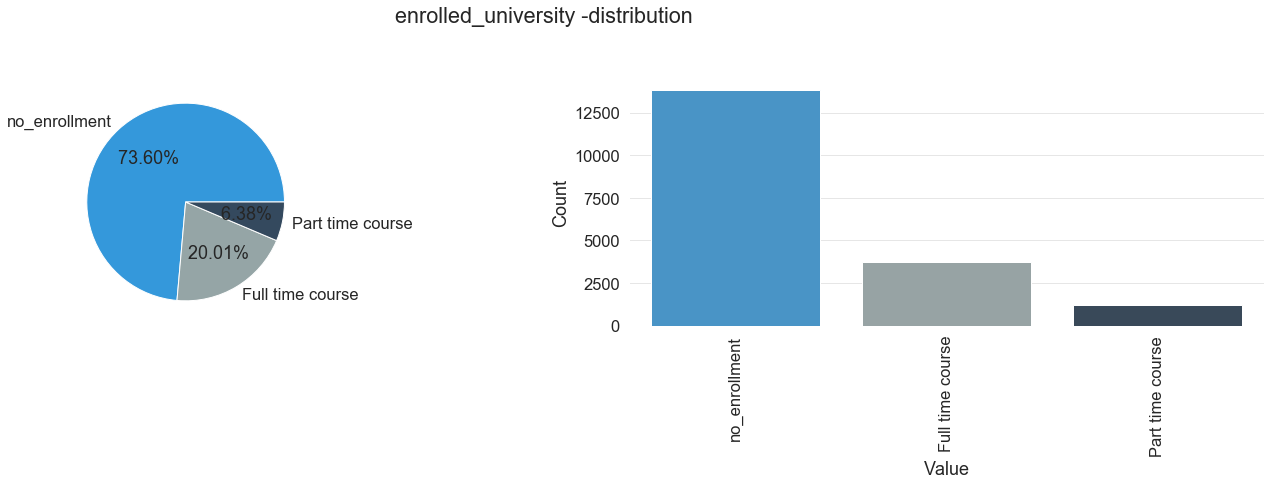

In [16]:
analyze_discrete_feature(df_train.enrolled_university)

### 7. education_level

Null value count :  460

Unique values:  ['Graduate', 'Masters', 'High School', nan, 'Phd', 'Primary School']

 Unique values count:  6

Value counts:
             Value  Count
0        Graduate  11598
1         Masters   4361
2     High School   2017
3             Phd    414
4  Primary School    308


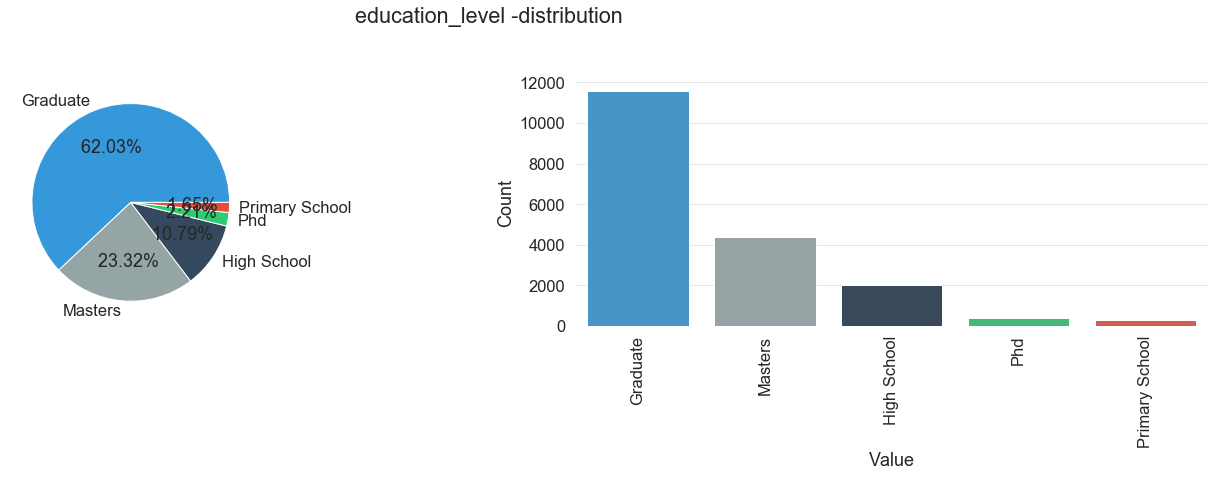

In [17]:
analyze_discrete_feature(df_train.education_level)

<h4 style='background-color:yellow'>
Most of the people are graduates.<br>
Very less people having Ph.D
</h4>

### 8. major_discipline

Null value count :  2813

Unique values:  ['STEM', 'Business Degree', nan, 'Arts', 'Humanities', 'No Major', 'Other']

 Unique values count:  7

Value counts:
              Value  Count
0             STEM  14492
1       Humanities    669
2            Other    381
3  Business Degree    327
4             Arts    253
5         No Major    223


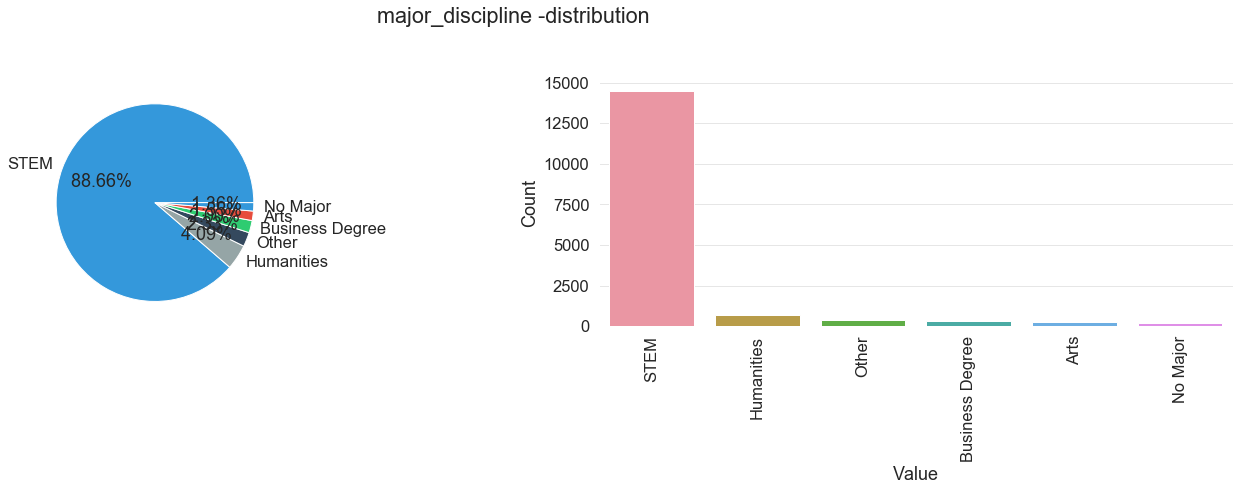

In [18]:
analyze_discrete_feature(df_train.major_discipline)

<h4 style='background-color:yellow'>
    Most of the candidates are from STEM (Science Technology Engineering and Mathematics) background.
</h4>


### 9. experience

Null value count :  65

Unique values:  ['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4', '10', '14', '18', '19', '12', '3', '6', '9', '8', '20', nan]

 Unique values count:  23

Value counts:
    Value  Count
0    >20   3286
1      5   1430
2      4   1403
3      3   1354
4      6   1216
5      2   1127
6      7   1028
7     10    985
8      9    980
9      8    802
10    15    686
11    11    664
12    14    586
13     1    549
14    <1    522
15    16    508
16    12    494
17    13    399
18    17    342
19    19    304
20    18    280
21    20    148


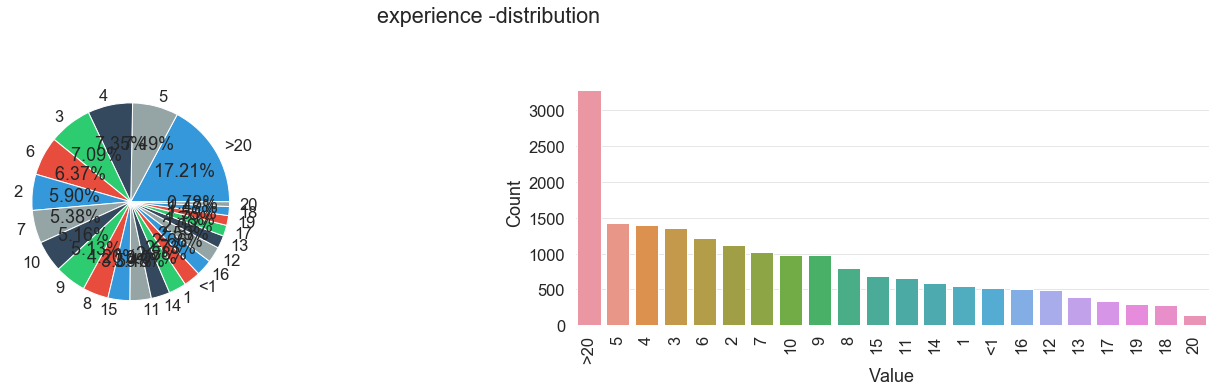

In [19]:
analyze_discrete_feature(df_train.experience)

### 10. Company_Size

Null value count :  5938

Unique values:  [nan, '50-99', '<10', '10000+', '5000-9999', '1000-4999', '10/49', '100-500', '500-999']

 Unique values count:  9

Value counts:
        Value  Count
0      50-99   3083
1    100-500   2571
2     10000+   2019
3      10/49   1471
4  1000-4999   1328
5        <10   1308
6    500-999    877
7  5000-9999    563


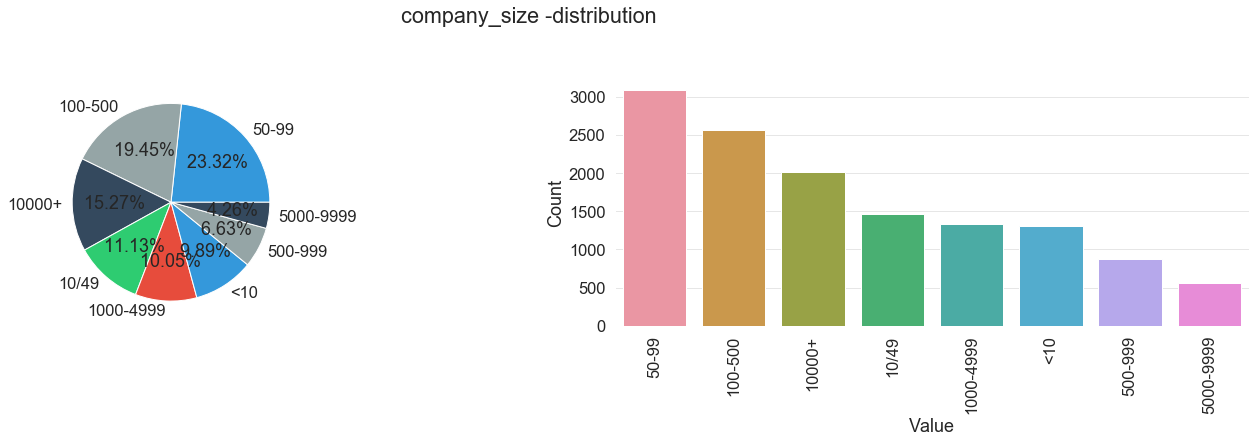

In [20]:
analyze_discrete_feature(df_train.company_size)

### 11. company_type

Null value count :  6140

Unique values:  [nan, 'Pvt Ltd', 'Funded Startup', 'Early Stage Startup', 'Other', 'Public Sector', 'NGO']

 Unique values count:  7

Value counts:
                  Value  Count
0              Pvt Ltd   9817
1       Funded Startup   1001
2        Public Sector    955
3  Early Stage Startup    603
4                  NGO    521
5                Other    121


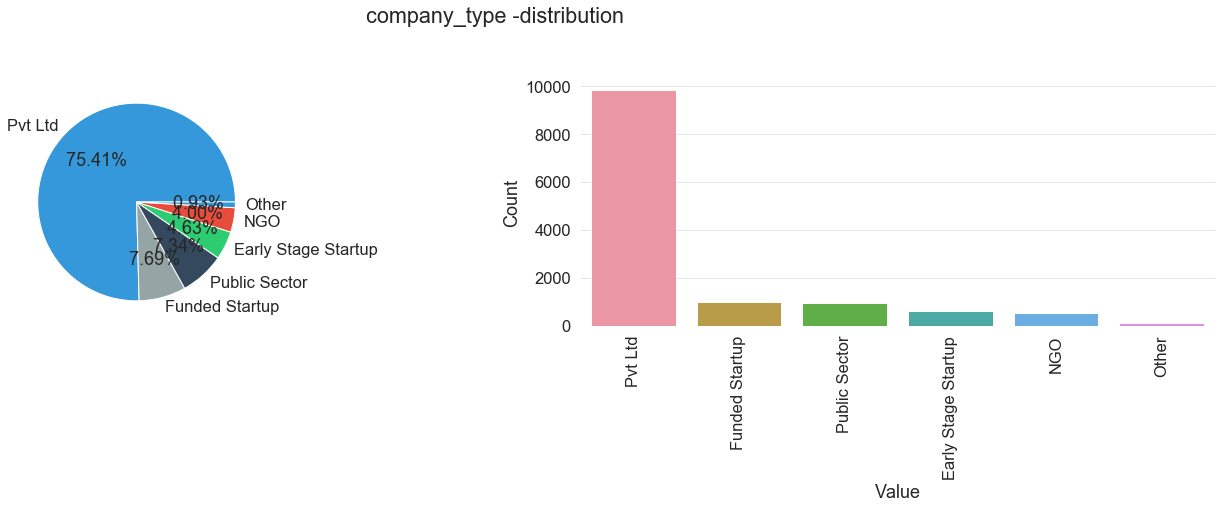

In [21]:
analyze_discrete_feature(df_train.company_type)

### 12. last_new_job

Null value count :  423

Unique values:  ['1', '>4', 'never', '4', '3', '2', nan]

 Unique values count:  7

Value counts:
    Value  Count
0      1   8040
1     >4   3290
2      2   2900
3  never   2452
4      4   1029
5      3   1024


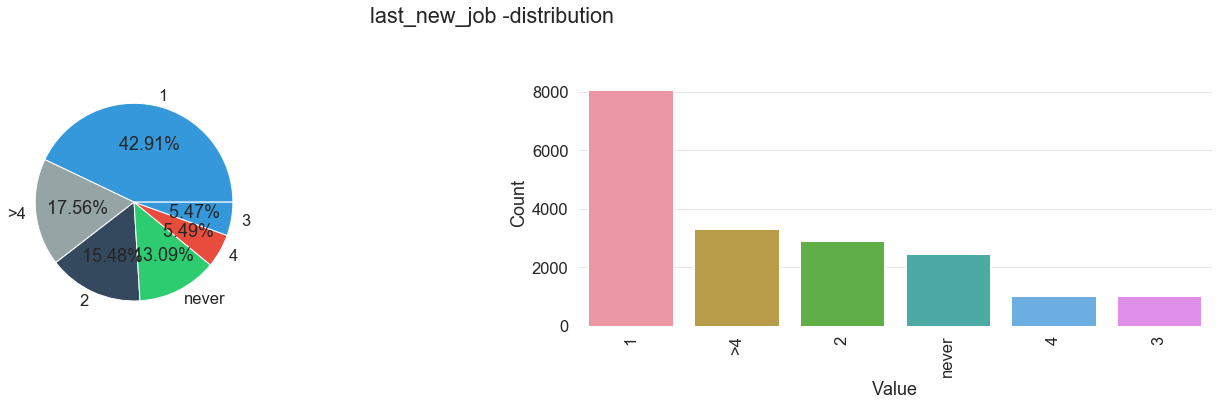

In [22]:
analyze_discrete_feature(df_train.last_new_job)

### 13. training_hours

Null value count :  0

 count    19158.000000
mean        65.366896
std         60.058462
min          1.000000
25%         23.000000
50%         47.000000
75%         88.000000
max        336.000000
Name: training_hours, dtype: float64


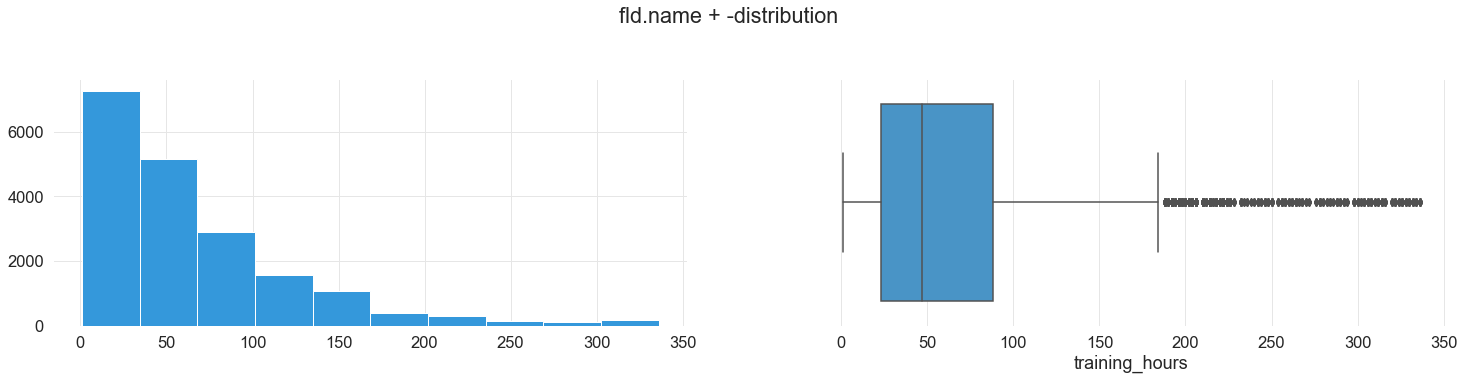

In [23]:
analyze_continuous_feature(df_train.training_hours)

### 14. target (Target Feature)

Null value count :  0

Unique values:  [1.0, 0.0]

 Unique values count:  2

Value counts:
    Value  Count
0    0.0  14381
1    1.0   4777


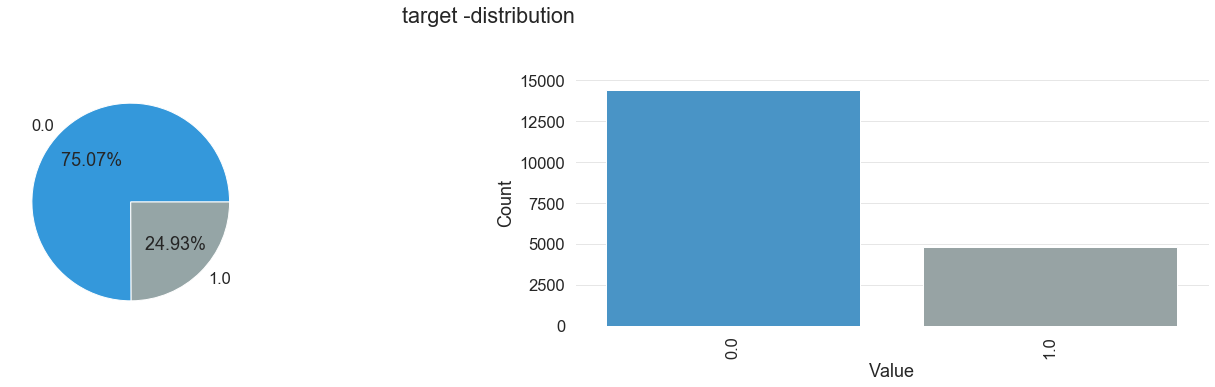

In [24]:
analyze_discrete_feature(df_train.target)

<h4 style='background-color:yellow'>
Target data is more favouring towards 0 class.
</h4>

## <center> Feature relationships</center>

### 1. Gender preference for company types

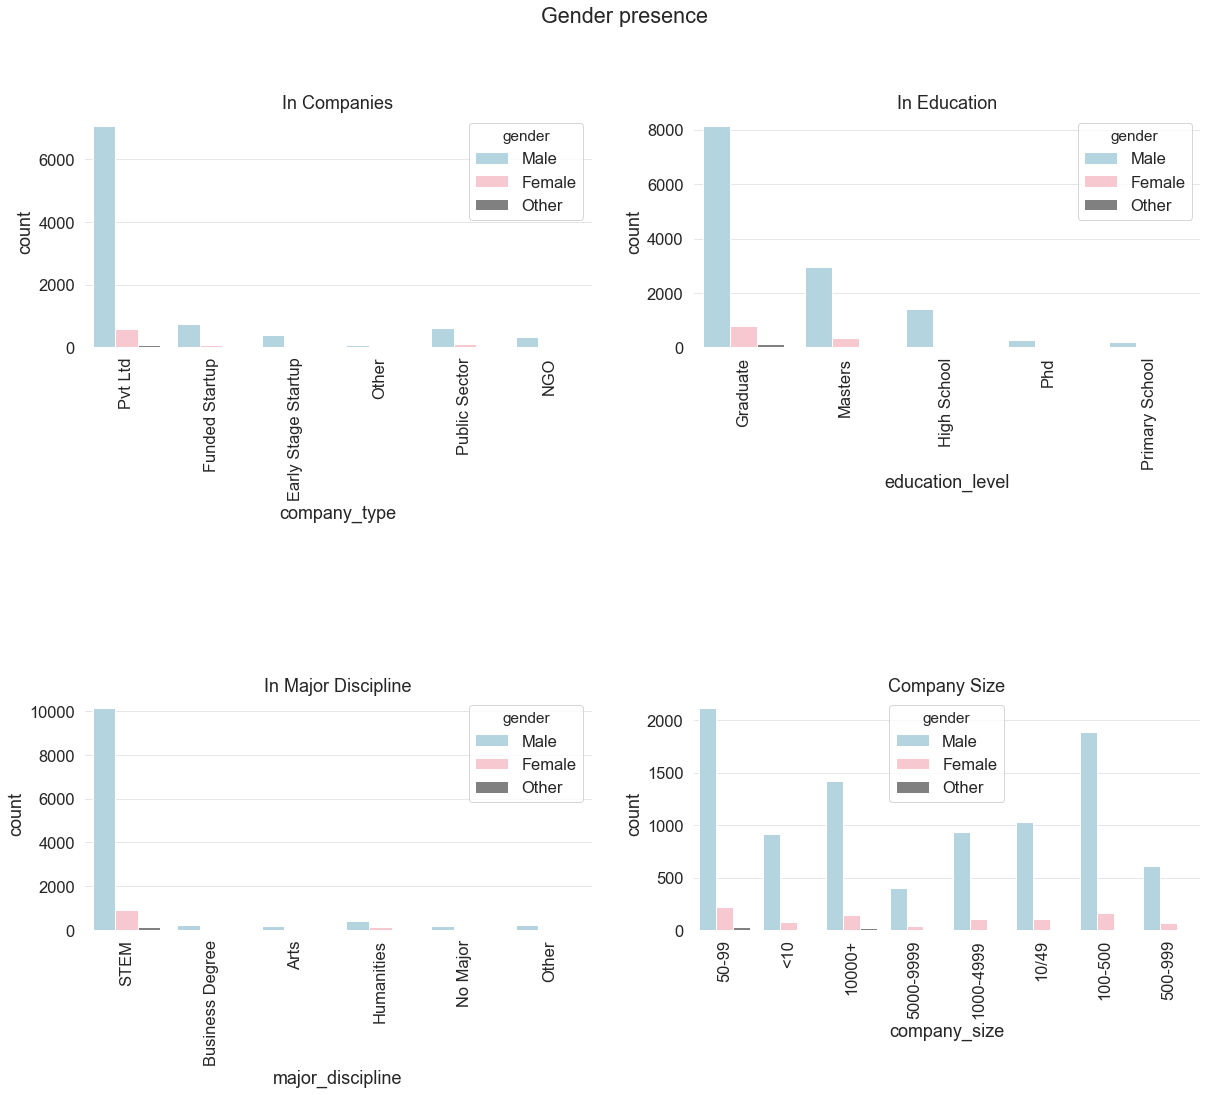

In [25]:
plt.subplots(figsize=(20,15))
plt.suptitle("Gender presence");
plt.subplots_adjust(hspace=1.5);

plt.subplot(2,2,1)
sns.countplot(data=df_train,x="company_type",hue="gender",palette=['#add8e6',"#FFC0CB","#808080"]);
plt.xticks(rotation=90)
plt.title("In Companies");

plt.subplot(2,2,2)
sns.countplot(data=df_train,x="education_level",hue="gender",palette=['#add8e6',"#FFC0CB","#808080"]);
plt.xticks(rotation=90);
plt.title("In Education");

plt.subplot(2,2,3);
sns.countplot(data=df_train,x="major_discipline",hue="gender",palette=['#add8e6',"#FFC0CB","#808080"]);
plt.xticks(rotation=90)
plt.title("In Major Discipline");

plt.subplot(2,2,4);
sns.countplot(data=df_train,x="company_size",hue="gender",palette=['#add8e6',"#FFC0CB","#808080"]);
plt.xticks(rotation=90)
plt.title("Company Size");

<h4 style='background-color:yellow'>
    In all company firms , Male dominance is more.<br>
    Private companies have more male population.<br>
    In all the education levels male dominance is more. <br>
    Females tends to work with company having 50-99 employee strength.<br>
</h4>

### 2. Educational qualifications hold by different types of company types.

In [26]:
df=df_train.loc[:,["company_type","education_level"]]
df=pd.crosstab(df.company_type,df.education_level)

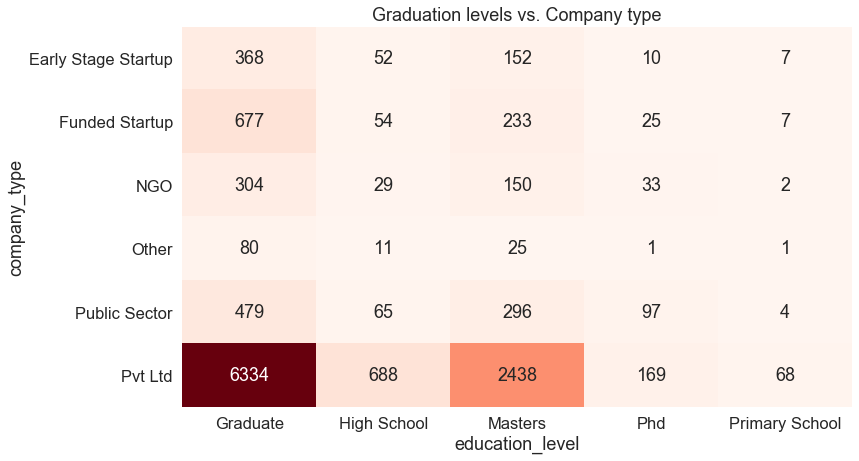

In [27]:
sns.heatmap(df,annot=True,fmt="g",cmap='Reds',cbar=False);
plt.title("Graduation levels vs. Company type");

<h4 style='background-color:yellow'>
Most of the people with all kinds of education levels tends to join in Private firms.<br>
</h4>

### 3. Experince vs. chances of job swich.

In [28]:
del(df)
df=df_train.copy()

In [29]:
df['experience'].replace(['<1','>20'],[0,21],inplace=True)
df["experience"]=pd.to_numeric(df.experience, errors='coerce')

In [30]:
def assign_experience_bin (fld):
    if fld <=5:
        return "beginer"
    elif (fld >5 and fld <=10):
        return "ascociate"
    elif (fld >10 and fld <=15):
        return "senior"
    elif (fld >15 and fld <=20):
        return "supersenior"
    elif fld > 20:
        return "experienced"
            

In [31]:
df["experience_bin"]=df['experience'].apply(assign_experience_bin)
df1=df.loc[:,['experience_bin','target','gender']]

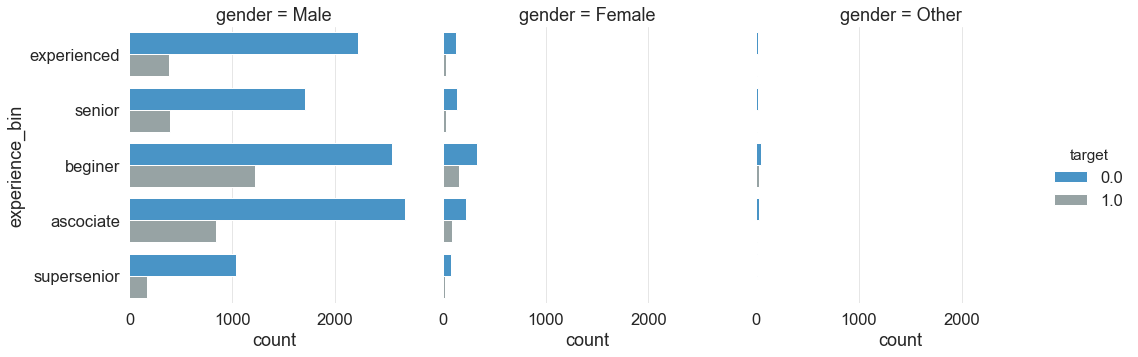

In [32]:
sns.catplot(data=df1,
           y="experience_bin",
           hue="target",
           kind="count",
           col="gender");

<h3 style='background-color:yellow'>
    People with experience level 0-15 tends to switch the job mostly. <br>
    People with experience level 25-20 will less likely switch the job compared to other experience level categories.
</h3>

In [33]:
del([df,df1])

## <center> Data Imputation</center>

In [34]:
def process_imputation(df):
    cmpny_type_mode=df['company_type'].mode()[0]
    df['company_type'].fillna(cmpny_type_mode,inplace=True)
    print (f"company_type missing values filled with: {cmpny_type_mode}\n")
    unique_cmpny_type=df.company_type.unique()
    group_cmpny_type=df.groupby('company_type')
    for cmpny in unique_cmpny_type:
        df_group=group_cmpny_type.get_group(cmpny)
        company_size_mode=df_group['company_size'].mode()[0]
        idx=df_group[pd.isnull(df_group["company_size"])].index
        df.loc[idx,"company_size"]=company_size_mode
        print (f"For company type {cmpny}, missing values for company size filled with: {company_size_mode}\n")
        
    gender_mod = df["gender"].mode()[0]
    df["gender"].fillna(gender_mod,inplace=True)
    print (f"Missing values for gender filled with: {gender_mod}\n")
    
    major_disciplie_mode=df["major_discipline"].mode()[0]
    df["major_discipline"].fillna(major_disciplie_mode,inplace=True)
    print (f"Missing values for major_discipline filled with: {major_disciplie_mode}\n")
    
    education_lvl_mod=df["education_level"].mode()[0]
    df['education_level'].fillna(education_lvl_mod,inplace=True)
    print(f"Missing values for education level filled with: {education_lvl_mod}\n")
    
    last_new_job_mode=df["last_new_job"].mode()[0]
    df["last_new_job"].fillna(last_new_job_mode,inplace=True)
    print (f"Missing values for last_new_job filled with: {last_new_job_mode}\n")
    
    enrolled_university_mode=df["enrolled_university"].mode()[0]
    df["enrolled_university"].fillna(enrolled_university_mode,inplace=True)
    print(f"Missing values for enrolled_university filled with: {enrolled_university_mode}\n")
    
    experience_mode=df["experience"].mode()[0]
    df_input["experience"].fillna(experience_mode,inplace=True)
    print(f"Missing values for experience filled with {experience_mode}\n")
    return df

In [35]:
#Cloning the dataset for further processing
df_input=df_train.copy()

In [36]:
df_input=process_imputation(df_input)

company_type missing values filled with: Pvt Ltd

For company type Pvt Ltd, missing values for company size filled with: 50-99

For company type Funded Startup, missing values for company size filled with: 50-99

For company type Early Stage Startup, missing values for company size filled with: <10

For company type Other, missing values for company size filled with: 100-500

For company type Public Sector, missing values for company size filled with: 1000-4999

For company type NGO, missing values for company size filled with: 100-500

Missing values for gender filled with: Male

Missing values for major_discipline filled with: STEM

Missing values for education level filled with: Graduate

Missing values for last_new_job filled with: 1

Missing values for enrolled_university filled with: no_enrollment

Missing values for experience filled with >20



In [37]:
print ("Is there any missing values?")
df_input.isnull().any()

Is there any missing values?


enrollee_id               False
city                      False
city_development_index    False
gender                    False
relevent_experience       False
enrolled_university       False
education_level           False
major_discipline          False
experience                False
company_size              False
company_type              False
last_new_job              False
training_hours            False
target                    False
dtype: bool

<h3 style="background-color:yellow">
Missing values removed from dataset.
    </h3>

## <center>Data wrangling    </center>

In [38]:
def wrangle_data(df):
    drop_features=["enrollee_id","city"]
    df.drop(drop_features,axis=1,inplace=True)

    #Create 3 major bins for city_development_index using the city_development_index
    #bin names : poor,average,high
    def get_bin(inp):
        bin_range=np.linspace(start=0,stop=1,num=4)
        if inp <= bin_range[1]:
            return 1
        elif bin_range[2] >= inp > bin_range[1]:
            return 2
        elif inp <= bin_range[3]:
            return 3
    df["city_development_index_bin"]=df["city_development_index"].apply(get_bin)
    df.drop("city_development_index",inplace=True,axis=1)
    
    df['experience'].replace(['>20','<1'],[21,0],inplace=True)
    df['experience']=df['experience'].apply(pd.to_numeric)
    
    df['company_size'].replace(['<10','10/49','50-99','100-500','500-999','1000-4999','5000-9999','10000+'],
                              [1,2,3,4,5,6,7,8],inplace=True)
    
    df['last_new_job'].replace(['never','1','2','3','4','>4'],list(range(0,6)),inplace=True)
    
    #Standardize continuous features
    df['training_hours']=standardize(df['training_hours'])
   
    df=pd.get_dummies(df)

    return df
    

In [39]:
df_input=wrangle_data(df_input)

In [40]:
df_input.columns

Index(['experience', 'company_size', 'last_new_job', 'training_hours',
       'target', 'city_development_index_bin', 'gender_Female', 'gender_Male',
       'gender_Other', 'relevent_experience_Has relevent experience',
       'relevent_experience_No relevent experience',
       'enrolled_university_Full time course',
       'enrolled_university_Part time course',
       'enrolled_university_no_enrollment', 'education_level_Graduate',
       'education_level_High School', 'education_level_Masters',
       'education_level_Phd', 'education_level_Primary School',
       'major_discipline_Arts', 'major_discipline_Business Degree',
       'major_discipline_Humanities', 'major_discipline_No Major',
       'major_discipline_Other', 'major_discipline_STEM',
       'company_type_Early Stage Startup', 'company_type_Funded Startup',
       'company_type_NGO', 'company_type_Other', 'company_type_Public Sector',
       'company_type_Pvt Ltd'],
      dtype='object')

In [41]:
df_input.describe().to_csv("dummy.csv")

In [42]:
x=df_input.drop('target',axis=1)
y=df_input.target
print (f"Shape of independent features {x.shape} \nShape of dependent feature {y.shape}")

Shape of independent features (19158, 30) 
Shape of dependent feature (19158,)


## <center>Model evaluation</center>

In [43]:
df_model_results=pd.DataFrame(columns=["ModelName","TrainScore"])

def store_model_results(modl_name,train_score):
    global df_model_results
    row_loc=df_model_results.shape[0]+1
    df_model_results.loc[row_loc,["ModelName","TrainScore"]]=[modl_name,train_score]


In [44]:
df_model_results=df_model_results.iloc[0:0]
for model in  tqdm([LogisticRegression(), 
               SVC(),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               KNeighborsClassifier(),
               XGBClassifier()]):
    store_model_results(model.__class__.__name__,
                       cross_val_score(model,x,y,cv=3).mean())
df_model_results.sort_values("TrainScore",ascending=False,inplace=True)
selected_model=df_model_results.head(1)["ModelName"].values[0]
display(HTML('<h3>Selected_model: '+ selected_model + '</h3>'))
df_model_results

100%|██████████| 6/6 [00:35<00:00,  5.90s/it]


,ModelName,TrainScore
2,SVC,0.776751
1,LogisticRegression,0.771375
6,XGBClassifier,0.764694
4,RandomForestClassifier,0.744389
5,KNeighborsClassifier,0.738856
3,DecisionTreeClassifier,0.686136


In [45]:
print ("Train Test file splitting..")
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1)
print (f"File shapes \nx_train:{x_train.shape} y_train:{y_train.shape}\nx_test:{x_test.shape} y_test:{y_test.shape}")

Train Test file splitting..
File shapes 
x_train:(14368, 30) y_train:(14368,)
x_test:(4790, 30) y_test:(4790,)


In [46]:
model=SVC()
model.fit(x_train,y_train)
print ("Predicting..")
y_pred=model.predict(x_test)

Predicting..


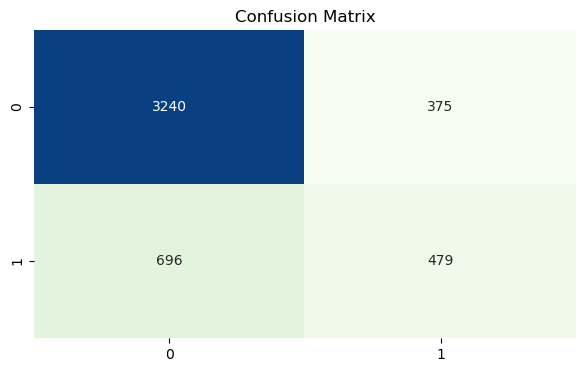

In [47]:
sns.reset_defaults()
plt.figure(figsize=(7,4));
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="GnBu",fmt="g",cbar=False);
plt.title("Confusion Matrix");

In [48]:
print ("Classification Report:\n")
print (classification_report(y_true=y_test,y_pred=y_pred))

Classification Report:

              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86      3615
         1.0       0.56      0.41      0.47      1175

    accuracy                           0.78      4790
   macro avg       0.69      0.65      0.67      4790
weighted avg       0.76      0.78      0.76      4790



<i>
Precision tp/(tp+fp) : measures the ability of a classifier to identify only the correct instances for each class.<br>
Recall tp/(tp+fn) : is the ability of the classifier to find all correct instances per class.<br>
F1 Score = 2 (precision recall)/ (precision + recall)<br>
F1 score is considered a better indicator of the classifier's performance than the regular accuracy measure.<br>
Support is the number of actual occurances of the class in the test data set.<br>
    </i>

In [68]:
print ("Let's tune the model and find the best hyper parameters..")

Let's tune the model and find the best hyper parameters..


In [58]:
#Lets find best hyper parameter for SVC
param_grid={'C':[0.1,1,10,100,1000],
           'gamma':[1,0.1,0.01,0.001,0.0001]}

In [59]:
grid=GridSearchCV(SVC(),param_grid=param_grid,refit=True,verbose=True,n_jobs=10)

In [60]:
grid.fit(x_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 125 out of 125 | elapsed: 15.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=10,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [61]:
print (grid.best_params_)

{'C': 10, 'gamma': 0.01}


In [62]:
print (grid.best_estimator_)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [63]:
y_pred_grid=grid.predict(x_test)

Classification Report:

              precision    recall  f1-score   support

         0.0       0.82      0.89      0.86      3615
         1.0       0.56      0.41      0.47      1175

    accuracy                           0.78      4790
   macro avg       0.69      0.65      0.67      4790
weighted avg       0.76      0.78      0.76      4790



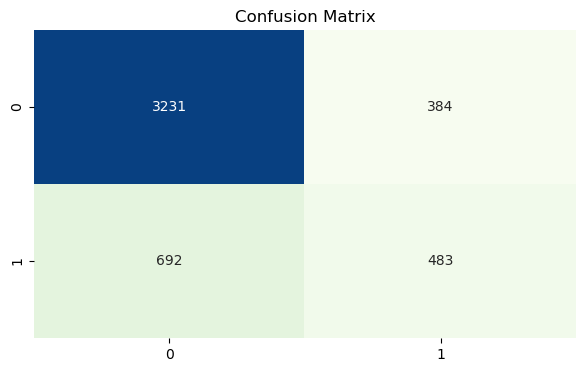

In [64]:
sns.reset_defaults()
plt.figure(figsize=(7,4));
sns.heatmap(confusion_matrix(y_test,y_pred_grid),annot=True,cmap="GnBu",fmt="g",cbar=False);
plt.title("Confusion Matrix");
print ("Classification Report:\n")
print (classification_report(y_true=y_test,y_pred=y_pred_grid))

Since the original model and tuned model almost giving similar results and original model had better recall score, We will make use of original model for predicting the results.

## <center> Test file prediction </center>

In [81]:
df_test=pd.read_csv('aug_test.csv')
#Cloning the dataset for further processing
df_input=df_test.copy()
print (f"Shape of the test file {df_input.shape}")

Shape of the test file (2129, 13)


In [82]:
column_id=df_test.enrollee_id

In [84]:
df_input=process_imputation(df_input)

company_type missing values filled with: Pvt Ltd

For company type Pvt Ltd, missing values for company size filled with: 50-99

For company type Funded Startup, missing values for company size filled with: 50-99

For company type Other, missing values for company size filled with: 50-99

For company type Public Sector, missing values for company size filled with: 100-500

For company type Early Stage Startup, missing values for company size filled with: <10

For company type NGO, missing values for company size filled with: 100-500

Missing values for gender filled with: Male

Missing values for major_discipline filled with: STEM

Missing values for education level filled with: Graduate

Missing values for last_new_job filled with: 1

Missing values for enrolled_university filled with: no_enrollment

Missing values for experience filled with >20



In [85]:
print ("Is there any missing values?")
df_input.isnull().any()

Is there any missing values?


enrollee_id               False
city                      False
city_development_index    False
gender                    False
relevent_experience       False
enrolled_university       False
education_level           False
major_discipline          False
experience                False
company_size              False
company_type              False
last_new_job              False
training_hours            False
dtype: bool

In [86]:
df_input.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours'],
      dtype='object')

In [87]:
df_input=wrangle_data(df_input)

In [88]:
x=df_input
print (f"Shape of independent features {x.shape}")

Shape of independent features (2129, 30)


In [89]:
y_pred=model.predict(x)

In [92]:
y_pred=pd.DataFrame({"enrollee_id":column_id,
                   "target":pd.Series(y_pred)})

In [94]:
y_pred.to_csv('submission.csv',index=False)
print ("Exported result")

Exported result
